In [0]:
dbutils.fs.rm("/tmp/delta/sales_data", recurse=True)
dbutils.fs.rm("/tmp/checkpoints/sales_data", recurse=True)

False

In [0]:

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()

json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

df = spark.read.json(json_file_path)
df.write.format("delta").mode("overwrite").save(delta_table_path)

while True:
    df = spark.read.format("delta").load(delta_table_path)

    print("\n" + "="*50)
    df.show(n=25, truncate=False)
    print("="*50 + "\n")
    
    time.sleep(10)




+-----------+------+------------------------------------+--------+----------+
|category   |price |product_id                          |quantity|timestamp |
+-----------+------+------------------------------------+--------+----------+
|Clothing   |476.06|d24a12d5-d642-47a6-83a3-ce2e46d33203|10      |2010-06-17|
|Apartments |495.71|e2766a1b-92c4-419d-8cb4-90a381e69fcc|9       |2015-05-15|
|Electronics|127.46|df1fdf80-004f-4aad-94a3-4a16810212f2|8       |2003-03-31|
|Clothing   |474.64|7ac23e86-33b7-4a8a-9796-6c166710e9c6|18      |2010-11-25|
|Groceries  |431.07|291df4af-ec64-4f7d-aab5-fd0064ccadc8|3       |2010-08-02|
|Clothing   |284.18|ea3c2a38-0738-42d4-aac2-abe92505dd7a|1       |1997-10-15|
|Apartments |462.74|986262e7-3994-48b5-b36a-b61705c01126|8       |2015-03-20|
|Clothing   |574.55|f46c49cb-2884-428b-bace-5494b6f168b1|2       |2002-09-19|
|Clothing   |170.12|811231d5-8b92-43e7-a8a4-b3ddda6a0782|14      |1999-12-16|
|Apartments |198.99|5a1930d6-a808-4805-8c1b-d387cb612bab|7     

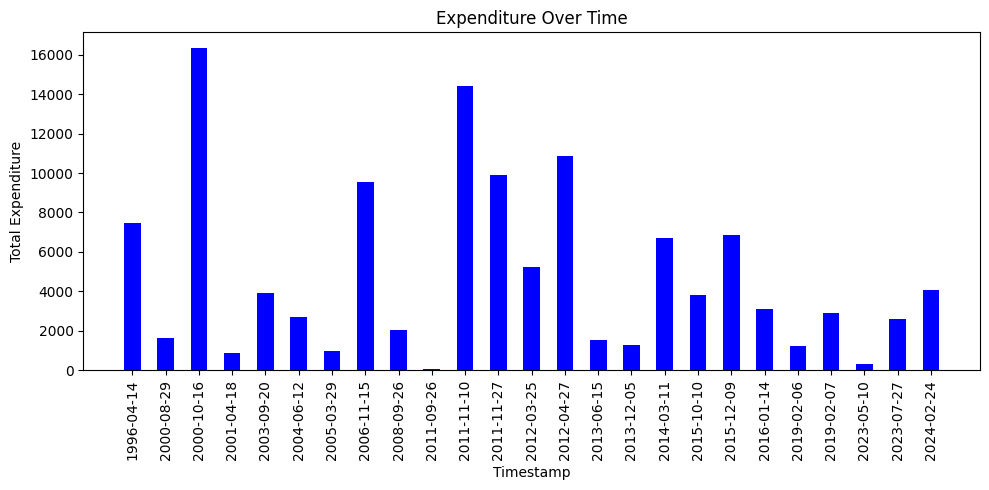

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()

json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

df = spark.read.json(json_file_path)
df.write.format("delta").mode("overwrite").save(delta_table_path)

df = spark.read.format("delta").load(delta_table_path)

data = df.select("timestamp", "quantity", "price", "category").collect()

if data:
    timestamps = [row.timestamp for row in data]  
    total_expenditure = [row.quantity * row.price for row in data]

    bef_sort_data = list(zip(timestamps, total_expenditure))
    sorted_data = sorted(bef_sort_data, key=lambda x: x[0])
    sorted_timestamps, sorted_total_expenditure = zip(*sorted_data)

    plt.figure(figsize=(10, 5))
    # plt.plot(timestamps, quantities, marker='o', linestyle='-', color='b')
    # plt.bar(timestamps, quantities, color='b', width=0.5)
    plt.bar(sorted_timestamps, sorted_total_expenditure, color='b', width=0.5)
    plt.title("Expenditure Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Total Expenditure")
    plt.xticks(rotation=90)  
    plt.tight_layout()  
    # plt.grid()  
    plt.show()
else:
    print("No data available in the DataFrame.")


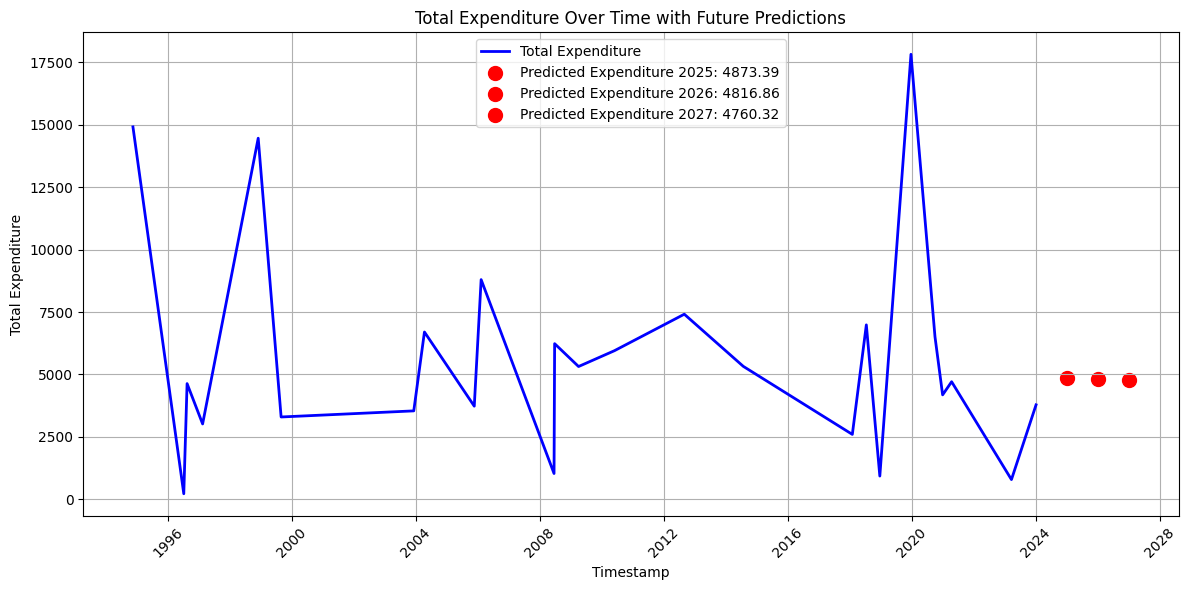

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()


json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

df = spark.read.json(json_file_path)
df.write.format("delta").mode("overwrite").save(delta_table_path)

df = spark.read.format("delta").load(delta_table_path)

data = df.select("timestamp", "quantity", "price", "category").collect()

if data:
    timestamps = [row.timestamp for row in data] 
    total_expenditure = [row.quantity * row.price for row in data]

    df_expenditure = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps),
        'total_expenditure': total_expenditure
    })

    df_expenditure = df_expenditure.groupby('timestamp').sum().reset_index()

    df_expenditure.sort_values('timestamp', inplace=True)

    df_expenditure['date_ordinal'] = df_expenditure['timestamp'].apply(lambda x: x.toordinal())
    X = df_expenditure['date_ordinal'].values.reshape(-1, 1)
    y = df_expenditure['total_expenditure'].values

    model = LinearRegression()
    model.fit(X, y)

    future_dates = []
    future_expenditures = []
    
    for year in [2025, 2026, 2027]:
        future_date = pd.to_datetime(f'{year}-01-01')
        future_dates.append(future_date)
        future_expenditure = model.predict(np.array([[future_date.toordinal()]]))[0]
        future_expenditures.append(future_expenditure)

    plt.figure(figsize=(12, 6))

    plt.plot(df_expenditure['timestamp'], df_expenditure['total_expenditure'], color='b', label='Total Expenditure', linewidth=2)

    for year, expenditure in zip([2025, 2026, 2027], future_expenditures):
        plt.scatter(pd.to_datetime(f'{year}-01-01'), expenditure, color='r', s=100, label=f'Predicted Expenditure {year}: {expenditure:.2f}')

    plt.title("Total Expenditure Over Time with Future Predictions")
    plt.xlabel("Timestamp")
    plt.ylabel("Total Expenditure")
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available in the DataFrame.")
